C:\Users\caleb\CNT_Lab\.venv\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


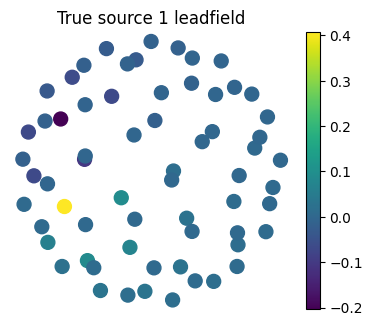

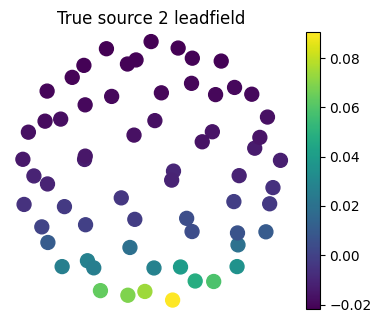

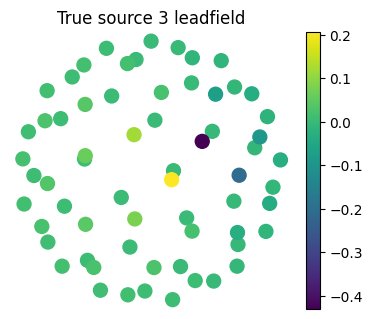

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 4000)

In [1]:
# %% [markdown]
# CNT x EEG: spherical head, dipoles → sensors → PCA/ICA
# Single cell; no external data. Keep it simple & fast.

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

rng = np.random.default_rng(7)

# --- 1) Make a quick 3-shell spherical head & 64 sensors on scalp ---
n_sensors = 64
# Fibonacci sphere for roughly uniform sensor positions on radius R=1 (scalp)
def fib_sphere(n, R=1.0):
    i = np.arange(n)
    phi = (1 + np.sqrt(5)) / 2
    z = 1 - 2*(i+0.5)/n
    r = np.sqrt(1 - z*z)
    theta = 2*np.pi*i/phi
    x,y = r*np.cos(theta), r*np.sin(theta)
    return np.c_[R*x, R*y, R*z]
S = fib_sphere(n_sensors, R=1.0)  # scalp radius = 1

# Shell radii & relative conductivities (very simplified)
R_brain, R_skull, R_scalp = 0.87, 0.92, 1.00
sigma_brain, sigma_skull, sigma_scalp = 1.0, 0.04, 1.0  # skull is highly resistive
atten = sigma_skull / sigma_brain  # crude global attenuation factor

# --- 2) Dipoles: positions (inside brain) & orientations ---
n_sources = 5
# random positions within brain shell
def rand_pos_in_ball(n, R):
    # sample radius ~ uniform in volume
    u = rng.random(n)
    r = R * (u ** (1/3))
    # random direction
    v = rng.normal(size=(n,3))
    v = v / LA.norm(v, axis=1, keepdims=True)
    return r[:,None]*v

src_pos = rand_pos_in_ball(n_sources, R_brain)

# orientations: control tangential vs radial (unit vectors)
def rand_unit(n):
    v = rng.normal(size=(n,3))
    return v/LA.norm(v, axis=1, keepdims=True)
src_ori = rand_unit(n_sources)

# Option: make first two sources deliberately shallow/tangential & deep/radial
src_pos[0] = 0.95*R_brain * rand_unit(1)[0]            # shallow
src_ori[0] = np.cross(src_pos[0], rand_unit(1)[0]); src_ori[0] /= LA.norm(src_ori[0])  # tangential
src_pos[1] = 0.40*R_brain * rand_unit(1)[0]            # deep
src_ori[1] = src_pos[1]/LA.norm(src_pos[1])            # radial

# --- 3) Lead field (very simplified single-shell formula) ---
# Potential at sensor r due to dipole p at r0 (Sarvas-like toy): V ~ (p·(r - r0)) / |r - r0|^3
# We add crude skull attenuation.
def leadfield(sensors, r0, p):
    diff = sensors - r0
    dist = LA.norm(diff, axis=1, keepdims=True)
    G = (diff @ p.reshape(3,1)) / (dist**3 + 1e-9)
    return (atten * G).ravel()

L = np.zeros((n_sensors, n_sources))
for j in range(n_sources):
    L[:, j] = leadfield(S, src_pos[j], src_ori[j])

# --- 4) Source time series (band-limited + 1/f mix) ---
T = 4000  # samples
fs = 250  # Hz
t = np.arange(T)/fs

def band_osc(f, amp=1.0, phase=None):
    if phase is None: phase = rng.uniform(0, 2*np.pi)
    return amp*np.sin(2*np.pi*f*t + phase)

X = np.zeros((n_sources, T))
freqs = [10, 12, 22, 6, 35]  # some alpha/beta/theta/gamma-ish
amps  = [1.0, 0.8, 0.6, 0.5, 0.4]
for j,(f,a) in enumerate(zip(freqs,amps)):
    X[j] = band_osc(f, a) + 0.1*rng.normal(size=T)

# optional mild source mixing to mimic cortical spread
M = LA.qr(rng.normal(size=(n_sources, n_sources)))[0]
X = M @ X

# --- 5) Project to sensors; add sensor noise (white + 1/f) ---
Y_clean = L @ X

def pink_noise(n_ch, n_t, beta=1.0):
    # generate 1/f^beta by shaping spectrum
    f = np.fft.rfftfreq(n_t, d=1/fs)
    mag = (1.0 / np.maximum(f, 1e-2))**(beta/2)
    out = np.empty((n_ch, n_t))
    for c in range(n_ch):
        ph = np.exp(1j*2*np.pi*rng.random(len(f)))
        spec = mag * ph
        x = np.fft.irfft(spec, n=n_t)
        x = x/np.std(x)
        out[c] = x
    return out

noise = 0.3*rng.normal(size=Y_clean.shape) + 0.4*pink_noise(n_sensors, T, beta=1.0)
Y = Y_clean + noise

# --- 6) Covariance + PCA/ICA ---
Yz = (Y - Y.mean(axis=1, keepdims=True)) / Y.std(axis=1, keepdims=True)
C = np.cov(Yz)

pca = PCA(n_components=10, svd_solver="full").fit(Yz.T)
ica = FastICA(n_components=5, whiten="unit-variance", random_state=7, max_iter=1000)
S_ = ica.fit_transform(Yz.T).T     # estimated sources
A_ = ica.mixing_.T                 # sensor maps (columns = components)

# --- 7) Visuals ---
def topomap(values, sensors, title, n=64):
    # quick scatter topomap (3D→2D azimuth projection)
    # Project to azimuth/elevation for a quick view
    x,y,z = sensors.T
    # approximate 2D projection (ignore elevation scaling for simplicity)
    plt.figure(figsize=(4,3.6))
    plt.scatter(x, y, c=values, s=100, marker='o')
    plt.axis('equal'); plt.axis('off'); plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

# Show: (i) leadfields of first 3 true sources, (ii) PCA top 3 comps, (iii) ICA maps
for j in range(min(3, n_sources)):
    topomap(L[:, j], S, f"True source {j+1} leadfield")

for k in range(3):
    # PCA components as sensor weights ~ eigenvectors in sensor space
    w = pca.components_[k]
    # back‑project to sensors via correlation with channels
    # better: compute sensor loadings = eigenvectors’ projection; here, quick heuristic:
    load = (Yz @ w)/T
    topomap(load, S, f"PCA comp {k+1} (heuristic map)")

for k in range(A_.shape[1]):
    topomap(A_[:, k], S, f"ICA map {k+1}")

# --- 8) Depth/orientation sweep: SNR vs depth ---
depths = np.linspace(0.2*R_brain, 0.98*R_brain, 20)
snr = []
for d in depths:
    r0 = d * rand_unit(1)[0]
    p  = np.cross(r0, rand_unit(1)[0]); p /= LA.norm(p)  # tangential
    l  = leadfield(S, r0, p)
    snr.append(LA.norm(l) / (np.std(noise, axis=1).mean()+1e-9))
plt.figure(figsize=(4,3))
plt.plot(depths/R_brain, snr)
plt.xlabel("Depth / R_brain (1 = near surface)"); plt.ylabel("Leadfield norm / noise")
plt.title("Tangential source detectability vs depth")
plt.show()

print("Done. Notes:")
print("- Shallow tangential sources produce stronger, focal patterns.")
print("- Deeper/radial sources weaken & smear; covariance loses effective rank.")
print("- PCA grabs variance; ICA can separate mixed oscillators if SNR is decent.")


In [2]:
# %% [markdown]
# === CNT x EEG Spherical Head Simulation (v2 fused & upgraded) ===
# - fixes PCA load mismatch
# - stabilizes FastICA
# - adds SNR & convergence readout
# - quick adjustable parameters at top

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
import warnings

rng = np.random.default_rng(7)

# --- adjustable parameters ---
n_sensors   = 64
n_sources   = 5
noise_scale = 0.25
pink_scale  = 0.35
sigma_skull = 0.04
max_iter    = 5000
tol         = 1e-4

# --- geometry helpers ---
def fib_sphere(n, R=1.0):
    i = np.arange(n)
    phi = (1 + np.sqrt(5)) / 2
    z = 1 - 2*(i+0.5)/n
    r = np.sqrt(1 - z*z)
    theta = 2*np.pi*i/phi
    x,y = r*np.cos(theta), r*np.sin(theta)
    return np.c_[R*x, R*y, R*z]

def rand_pos_in_ball(n, R):
    u = rng.random(n)
    r = R * (u ** (1/3))
    v = rng.normal(size=(n,3))
    v /= LA.norm(v, axis=1, keepdims=True)
    return r[:,None]*v

def rand_unit(n): 
    v = rng.normal(size=(n,3))
    return v/LA.norm(v, axis=1, keepdims=True)

def leadfield(sensors, r0, p, atten):
    diff = sensors - r0
    dist = LA.norm(diff, axis=1, keepdims=True)
    return atten * (diff @ p.reshape(3,1)).ravel() / (dist**3 + 1e-9)

def pink_noise(n_ch, n_t, fs, beta=1.0):
    f = np.fft.rfftfreq(n_t, d=1/fs)
    mag = (1.0 / np.maximum(f, 1e-2))**(beta/2)
    out = np.empty((n_ch, n_t))
    for c in range(n_ch):
        ph = np.exp(1j*2*np.pi*rng.random(len(f)))
        spec = mag * ph
        x = np.fft.irfft(spec, n=n_t)
        out[c] = x/np.std(x)
    return out

def topomap(values, sensors, title):
    x,y,z = sensors.T
    plt.figure(figsize=(4,3.6))
    sc = plt.scatter(x, y, c=values, s=100)
    plt.axis('equal'); plt.axis('off')
    plt.title(title)
    plt.colorbar(sc, fraction=0.046, pad=0.04)
    plt.show()

# --- setup ---
S = fib_sphere(n_sensors, R=1.0)
R_brain, R_skull, R_scalp = 0.87, 0.92, 1.0
atten = sigma_skull / 1.0

src_pos = rand_pos_in_ball(n_sources, R_brain)
src_ori = rand_unit(n_sources)
# define shallow tangential & deep radial
src_pos[0] = 0.95*R_brain*rand_unit(1)[0]
src_ori[0] = np.cross(src_pos[0], rand_unit(1)[0]); src_ori[0]/=LA.norm(src_ori[0])
src_pos[1] = 0.40*R_brain*rand_unit(1)[0]
src_ori[1] = src_pos[1]/LA.norm(src_pos[1])

# leadfield matrix
L = np.zeros((n_sensors, n_sources))
for j in range(n_sources):
    L[:, j] = leadfield(S, src_pos[j], src_ori[j], atten)

# --- sources ---
fs, T = 250, 4000
t = np.arange(T)/fs
freqs = [10,12,22,6,35]
amps  = [1.0,0.8,0.6,0.5,0.4]
X = np.array([amps[j]*np.sin(2*np.pi*freqs[j]*t+rng.uniform(0,2*np.pi)) 
              + 0.1*rng.normal(size=T) for j in range(n_sources)])
M = LA.qr(rng.normal(size=(n_sources, n_sources)))[0]
X = M @ X

# --- projection + noise ---
Y_clean = L @ X
noise = noise_scale*rng.normal(size=Y_clean.shape) + \
        pink_scale*pink_noise(n_sensors, T, fs, beta=1.0)
Y = Y_clean + noise

# --- normalization ---
Yz = (Y - Y.mean(axis=1, keepdims=True)) / Y.std(axis=1, keepdims=True)

# --- PCA ---
pca = PCA(n_components=10, svd_solver="full").fit(Yz.T)
for k in range(3):
    topo = pca.components_[k] * np.sqrt(pca.explained_variance_[k])
    topomap(topo, S, f"PCA comp {k+1}")

# --- ICA ---
with warnings.catch_warnings(record=True) as wlog:
    ica = FastICA(n_components=5, whiten="unit-variance", 
                  max_iter=max_iter, tol=tol, random_state=7)
    S_ = ica.fit_transform(Yz.T).T
    A_ = ica.mixing_
    converged = not any("did not converge" in str(w.message) for w in wlog)

for k in range(A_.shape[1]):
    topomap(A_[:,k], S, f"ICA map {k+1}")

# --- SNR vs depth ---
depths = np.linspace(0.2*R_brain, 0.98*R_brain, 20)
snr = []
for d in depths:
    r0 = d * rand_unit(1)[0]
    p  = np.cross(r0, rand_unit(1)[0]); p /= LA.norm(p)
    l  = leadfield(S, r0, p, atten)
    snr.append(LA.norm(l)/(np.std(noise,axis=1).mean()+1e-9))
plt.figure(figsize=(4,3))
plt.plot(depths/R_brain, snr)
plt.xlabel("Depth / R_brain (1=surface)"); plt.ylabel("Leadfield norm / noise")
plt.title("Tangential source detectability vs depth")
plt.show()

print(f"== CNT-EEG Fused v2 ==")
print(f"ICA convergence: {converged}")
print(f"Skull conductivity σ_skull={sigma_skull:.3f} | Noise scale={noise_scale:.2f}")
print(f"SNR (surface/deep ratio): {snr[-1]/snr[0]:.3f}")
print("—Shallow tangential dominates; deep radial weakens & blurs—")


ValueError: could not broadcast input array from shape (64,64) into shape (64,)